<a href="https://colab.research.google.com/github/ben-wycliff/dl_final_project/blob/main/nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip dataset from google drive
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/known_images.zip

Archive:  /content/drive/MyDrive/Personal/Computer Vision/dl_final_project/known_images.zip
   creating: known_images/
  inflating: known_images/normal_0.png  
  inflating: known_images/normal_1.png  
  inflating: known_images/normal_10.png  
  inflating: known_images/normal_101.png  
  inflating: known_images/normal_102.png  
  inflating: known_images/normal_103.png  
  inflating: known_images/normal_104.png  
  inflating: known_images/normal_105.png  
  inflating: known_images/normal_106.png  
  inflating: known_images/normal_107.png  
  inflating: known_images/normal_108.png  
  inflating: known_images/normal_109.png  
  inflating: known_images/normal_11.png  
  inflating: known_images/normal_110.png  
  inflating: known_images/normal_111.png  
  inflating: known_images/normal_112.png  
  inflating: known_images/normal_113.png  
  inflating: known_images/normal_114.png  
  inflating: known_images/normal_115.png  
  inflating: known_images/normal_116.png  
  inflating: known_images/n

# Prepare Dataset

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# create dataframe
images = os.listdir("./known_images")
labels = ["0" if "normal" in i  else "1" for i in images]
df = pd.DataFrame({
    "images": images,
    "labels": labels
})
df.to_csv("dataset.csv")
df.head(10) # all sick images are labelled 1 while normal images are labelled 2

,images,labels
0,normal_81.png,0
1,normal_22.png,0
2,sick_292.png,1
3,normal_222.png,0
4,sick_67.png,1
5,sick_299.png,1
6,normal_128.png,0
7,sick_183.png,1
8,normal_657.png,0
9,sick_350.png,1


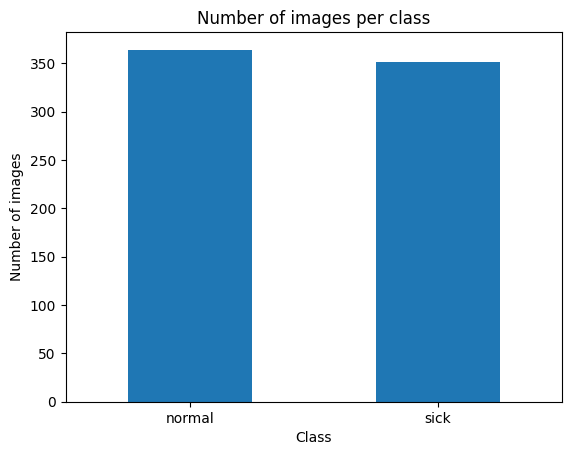

In [ ]:
# From this plot we see the number of images is fairly
# distributed between the two classes
df.labels.value_counts().plot(kind="bar"); 
plt.title("Number of images per class")
plt.xticks(ticks=[0,1],labels=["normal", "sick"], rotation=0)
plt.ylabel("Number of images")
plt.xlabel("Class")
plt.show()

In [ ]:
# create dataset splits
from sklearn.model_selection import train_test_split
df_train, df_eval = train_test_split(df, test_size=0.3, random_state=0)
df_test, df_val = train_test_split(df_eval, test_size=0.33, random_state=0)

In [ ]:
# subplot the partitioning results
print("\nTrain partition:\n", df_train.labels.value_counts())
print("\nTest partition:\n", df_test.labels.value_counts())
print("\nValidation partition:\n", df_val.labels.value_counts())


Train partition:
 0    256
1    244
Name: labels, dtype: int64

Test partition:
 1    73
0    71
Name: labels, dtype: int64

Validation partition:
 0    37
1    34
Name: labels, dtype: int64


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# create data generators
train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    rescale=1.0/255.0,
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory="./known_images",
                                                    x_col="images",
                                                    y_col="labels",
                                                    target_size=(391, 488),
                                                    class_mode="binary",
                                                    batch_size=32)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory="./known_images",
                                                  x_col="images",
                                                  y_col="labels",
                                                  target_size=(391, 488),
                                                  class_mode="binary",
                                                  shuffle=False,
                                                  batch_size=32)

val_generator = test_datagen.flow_from_dataframe(dataframe=df_val,
                                                  directory="./known_images",
                                                  x_col="images",
                                                  y_col="labels",
                                                 target_size=(391, 488),
                                                  class_mode="binary",
                                                 shuffle=False,
                                                  batch_size=32)

Found 500 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.
Found 71 validated image filenames belonging to 2 classes.


# Train the model

In [ ]:
import keras
from keras import layers

In [ ]:
model = keras.Sequential(
    [
      layers.Conv2D(32, (3,3), activation="relu", input_shape=(391, 488, 3)),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(128, (3,3), activation="relu"),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(32, activation="relu"),
      layers.Dense(1, activation="sigmoid")
    ]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 389, 486, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 194, 243, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 192, 241, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 96, 120, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 94, 118, 64)       36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 47, 59, 64)      

In [ ]:
# optimizer
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, epochs=20, batch_size=32, validation_data=val_generator)

Epoch 1/20
16/16 [==============================] - 41s 2s/step - loss: 0.6860 - accuracy: 0.5960 - val_loss: 0.4517 - val_accuracy: 0.8028
Epoch 2/20
16/16 [==============================] - 23s 1s/step - loss: 0.3891 - accuracy: 0.8120 - val_loss: 0.1784 - val_accuracy: 0.9437
Epoch 3/20
16/16 [==============================] - 25s 2s/step - loss: 0.3673 - accuracy: 0.8240 - val_loss: 0.3066 - val_accuracy: 0.8310
Epoch 4/20
16/16 [==============================] - 24s 1s/step - loss: 0.2845 - accuracy: 0.8960 - val_loss: 0.1456 - val_accuracy: 0.9437
Epoch 5/20
16/16 [==============================] - 22s 1s/step - loss: 0.2255 - accuracy: 0.9100 - val_loss: 0.1101 - val_accuracy: 0.9718
Epoch 6/20
16/16 [==============================] - 24s 1s/step - loss: 0.1678 - accuracy: 0.9240 - val_loss: 0.0933 - val_accuracy: 0.9577
Epoch 7/20
16/16 [==============================] - 23s 1s/step - loss: 0.1647 - accuracy: 0.9320 - val_loss: 0.3651 - val_accuracy: 0.8592
Epoch 8/20
16/16 [==

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


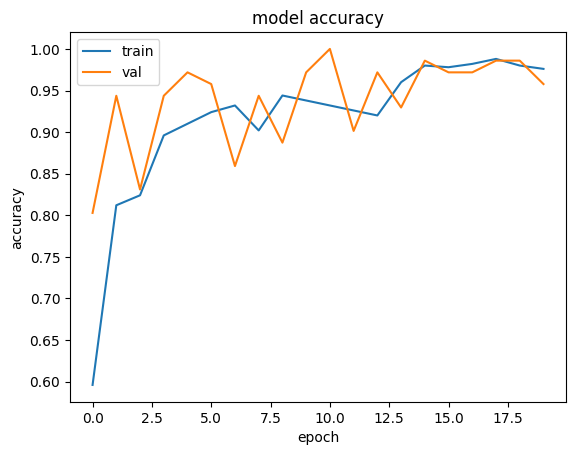

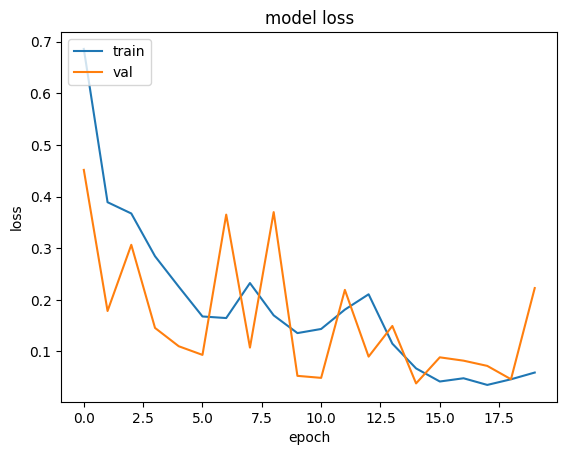

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_generator)

5/5 [==============================] - 1s 210ms/step - loss: 0.1324 - accuracy: 0.9583


[0.1324157416820526, 0.9583333134651184]

In [ ]:
y_true = test_generator.classes

In [ ]:
y_pred = model.predict(test_generator)

5/5 [==============================] - 1s 220ms/step


In [ ]:
y_pred = [1 if i > 0.5 else 0 for i in y_pred]

In [ ]:
y_pred.count(0)

77

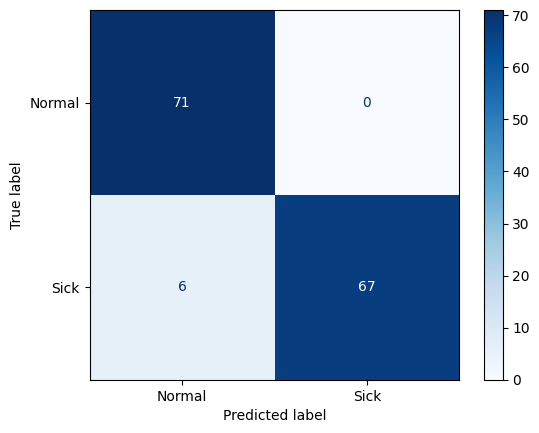

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
def plot_confusion_matrix(y_test, y_pred, labels):
  """
    y_test: true y labels
    y_pred: predicted y labels
    labels: class labels
  """
  disp = ConfusionMatrixDisplay.from_predictions(y_test,
                                                 y_pred,
                                                 display_labels=labels,
                                                 cmap="Blues")

plot_confusion_matrix( y_true, y_pred, ["Normal", "Sick"])

# Test on unknown dataset

In [ ]:
# unzip dataset from google drive
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/dataset2.zip

Archive:  /content/drive/MyDrive/Personal/Computer Vision/dl_final_project/dataset2.zip
replace images/sick_eff0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: images/sick_eff0.png    
  inflating: images/sick_eff1.png    
  inflating: images/sick_eff10.png   
  inflating: images/sick_eff100.png  
  inflating: images/sick_eff101.png  
  inflating: images/sick_eff102.png  
  inflating: images/sick_eff103.png  
  inflating: images/sick_eff104.png  
  inflating: images/sick_eff105.png  
  inflating: images/sick_eff106.png  
  inflating: images/sick_eff107.png  
  inflating: images/sick_eff108.png  
  inflating: images/sick_eff109.png  
  inflating: images/sick_eff11.png   
  inflating: images/sick_eff110.png  
  inflating: images/sick_eff111.png  
  inflating: images/sick_eff12.png   
  inflating: images/sick_eff13.png   
  inflating: images/sick_eff14.png   
  inflating: images/sick_eff15.png   
  inflating: images/sick_eff16.png   
  inflating: images/sick_eff17.png   
  infl

In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/Personal/Computer Vision/dl_final_project/dataset2_image_classes.csv")

In [ ]:
df2.head()

,patient,"diagnosis (0-Normal, 1-Sick)"
0,sick_eff0,0
1,sick_eff1,0
2,sick_eff2,0
3,sick_eff3,0
4,sick_eff4,0


In [ ]:
df2.keys()

Index(['patient ', 'diagnosis (0-Normal, 1-Sick)'], dtype='object')

In [ ]:
df2["patient "] = df2["patient "]+".png"
df2["diagnosis (0-Normal, 1-Sick)"] = df2["diagnosis (0-Normal, 1-Sick)"].astype(str)
df2.head()

,patient,"diagnosis (0-Normal, 1-Sick)"
0,sick_eff0.png,0
1,sick_eff1.png,0
2,sick_eff2.png,0
3,sick_eff3.png,0
4,sick_eff4.png,0


In [ ]:
dataset2_generator = test_datagen.flow_from_dataframe(dataframe=df2,
                                                      directory="./images",
                                                      x_col="patient ",
                                                      y_col="diagnosis (0-Normal, 1-Sick)",
                                                      target_size=(391, 488),
                                                      class_mode="binary",
                                                      shuffle=False,
                                                      batch_size=32)

Found 224 validated image filenames belonging to 2 classes.


In [ ]:
model.evaluate(dataset2_generator)

7/7 [==============================] - 2s 246ms/step - loss: 5.1729 - accuracy: 0.4821


[5.1728739738464355, 0.4821428656578064]

# Evaluate on unknown images

In [ ]:
!unzip /content/drive/MyDrive/Personal/Computer\ Vision/dl_final_project/unknown_images.zip

Archive:  /content/drive/MyDrive/Personal/Computer Vision/dl_final_project/unknown_images.zip
   creating: unknown_images/
  inflating: unknown_images/1.png    
  inflating: unknown_images/10.png   
  inflating: unknown_images/11.png   
  inflating: unknown_images/12.png   
  inflating: unknown_images/13.png   
  inflating: unknown_images/14.png   
  inflating: unknown_images/15.png   
  inflating: unknown_images/16.png   
  inflating: unknown_images/17.png   
  inflating: unknown_images/18.png   
  inflating: unknown_images/19.png   
  inflating: unknown_images/2.png    
  inflating: unknown_images/20.png   
  inflating: unknown_images/21.png   
  inflating: unknown_images/22.png   
  inflating: unknown_images/23.png   
  inflating: unknown_images/24.png   
  inflating: unknown_images/25.png   
  inflating: unknown_images/26.png   
  inflating: unknown_images/27.png   
  inflating: unknown_images/28.png   
  inflating: unknown_images/29.png   
  inflating: unknown_images/3.png    
  i

In [ ]:
!ls ./unknow_data/unknown_images

10.png	15.png	1.png	24.png	29.png	33.png	38.png	42.png	47.png	5.png
11.png	16.png	20.png	25.png	2.png	34.png	39.png	43.png	48.png	6.png
12.png	17.png	21.png	26.png	30.png	35.png	3.png	44.png	49.png	7.png
13.png	18.png	22.png	27.png	31.png	36.png	40.png	45.png	4.png	8.png
14.png	19.png	23.png	28.png	32.png	37.png	41.png	46.png	50.png	9.png


In [ ]:
unknown_generator = test_datagen.flow_from_directory(
    directory="./unknown_data/",
    target_size=(391, 488),
    class_mode="binary",
    shuffle=False,
    batch_size=50
)

Found 50 images belonging to 3 classes.


In [ ]:
prediction = model.predict(unknown_generator, steps=len(unknown_generator))

1/1 [==============================] - 2s 2s/step


In [ ]:
prediction = [1 if i > 0.5 else 0 for i in prediction]

In [ ]:
prediction.count(0)

27

In [ ]:
prediction.count(1)

23